# Homework 2 Exercise 1 - Bayesian Belief Network

Brennan McFarland   
bfm21

(a) Create a Bayesian Belief Network with binary or discrete variables using pgmpy or
PyMC3. Follow the example covered in class.

# Problem Description

Suppose an autonomous robot has a depth sensor mounted on it that repeatedly samples whether there is currently an obstacle in front of it (C).  The robot is programmed to take evasive maneuvers whenever an obstacle comes within its sensor distance (O), but there is also random noise in the sensor readings that can indicate an obstacle exists where there is none and vice versa (N).  The robot also keeps track of the last depth sensor reading (L), as a positive reading is more likely to be an actual obstacle rather than noise if it is persistent across samples.  Let us suppose that given a certain set of sensor data we want the probability that there is an obstacle in the way.

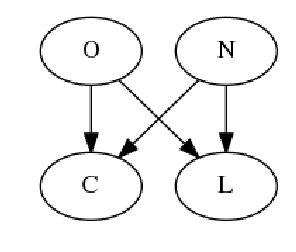

In [17]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as imtool

image_format = 'png'
dot = Digraph(format=image_format)
dot.node('O', 'O')
dot.node('N', 'N')
dot.node('C', 'C')
dot.node('L', 'L')
dot.edges(['OC', 'OL', 'NC', 'NL'])
path = 'exercise1-graph'
dot.render(path)
imorg = imtool.imread(path + '.' + image_format)
plt.axis('off')
plt.imshow(imorg) # NOTE: the first time it doesn't show the image, if it doesn't just execute this block again

# Probabilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


p_c = p_l = .3
p_o = .2
p_n = .3

print("Suppose the robot is preprogrammed with the following prior probabilities:");
print("P(C) = ", p_c)
print("P(L) = ", p_l)
print("P(O) = ", p_o)
print("P(N) = ", p_n)

p_c_given_o_n = p_l_given_o_n = .96
p_c_given_o_not_n = p_l_given_o_not_n = .9
p_c_given_not_o_n = p_l_given_not_o_n = .4
p_c_given_not_o_not_n = p_l_given_not_o_not_n = .01

print("And the following conditional probabilities:")
print("P(C|O,N) = ", p_c_given_o_n)
print("P(C|O,~N) = ", p_c_given_o_not_n)
print("P(C|~O,N) = ", p_c_given_not_o_n)
print("P(C|~O,~N) = ", p_c_given_not_o_not_n)
print("P(L|O,N) = ", p_l_given_o_n)
print("P(L|O,~N) = ", p_l_given_o_not_n)
print("P(L|~O,N) = ", p_l_given_not_o_n)
print("P(L|~O,~N) = ", p_l_given_not_o_not_n)

Suppose the robot is preprogrammed with the following prior probabilities:
P(C) =  0.3
P(L) =  0.3
P(O) =  0.2
P(N) =  0.3
And the following conditional probabilities:
P(C|O,N) =  0.96
P(C|O,~N) =  0.9
P(C|~O,N) =  0.4
P(C|~O,~N) =  0.01
P(L|O,N) =  0.96
P(L|O,~N) =  0.9
P(L|~O,N) =  0.4
P(L|~O,~N) =  0.01


Let us define the corresponding Bayesian Belief Network Model in PyMC3 as follows:

In [2]:
import pymc3
from pymc3 import Bernoulli
from pymc3.math import switch

model = pymc3.Model()

with model:
    o = Bernoulli('Obstacle', p_o)
    n = Bernoulli('Noise', p_n)
    c = Bernoulli('Current reading', switch(o, switch(n, p_c_given_o_n, p_c_given_o_not_n), switch(n, p_c_given_not_o_n, p_c_given_not_o_not_n)))
    l = Bernoulli('Last reading', switch(o, switch(n, p_l_given_o_n, p_l_given_o_not_n), switch(n, p_l_given_not_o_n, p_l_given_not_o_not_n)))
    

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/user/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Sample Generation

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [Obstacle, Noise, Current reading, Last reading]
100%|██████████| 20500/20500 [00:19<00:00, 1046.93it/s]
The number of effective samples is smaller than 25% for some parameters.


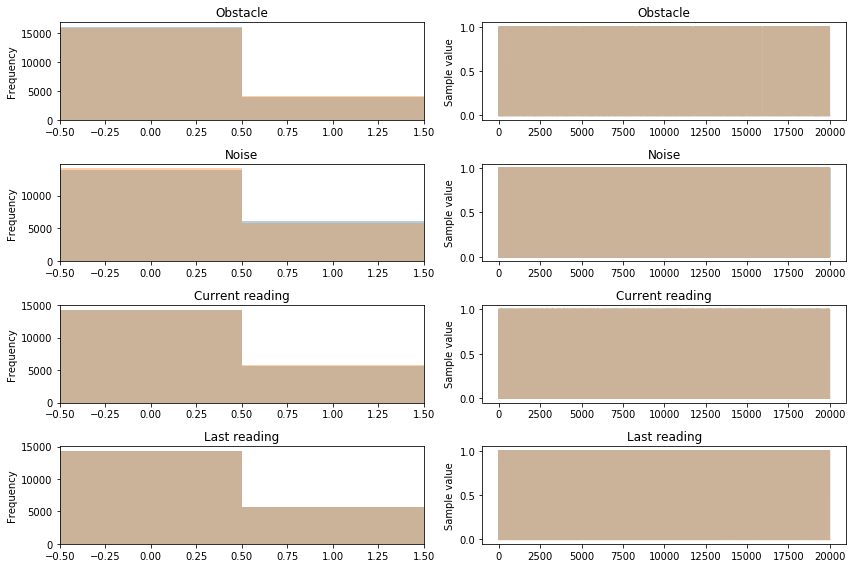

In [3]:
%matplotlib inline
samples = 20000
with model:
    trace = pymc3.sample(samples, chains=2)
    pymc3.traceplot(trace)

# Posterior Inference

In [4]:
def conditional_probability(trace, event, cond):
    # find all samples satisfy conditions
    for k, v in cond.items():
        trace = [smp for smp in trace if smp[k] == v]
    # record quantity of all samples fulfill condition
    nCondSample = len(trace)
    # find all samples satisfy event
    for k, v in event.items():
        trace = [smp for smp in trace if smp[k] == v]
    # calculate conditional probability
    return len(trace) / nCondSample

Now we can calculate the posteriors probabilities of obstacles being in the way for all possible sensor data:

In [6]:
print('P(O|C,L) = ',
     conditional_probability(trace,
                            {'Obstacle' : 1},
                            {'Current reading' : 1, 'Last reading' : 1}))
print('P(O|C,~L) = ',
     conditional_probability(trace,
                            {'Obstacle' : 1},
                            {'Current reading' : 1, 'Last reading' : 0}))
print('P(O|~C,L) = ',
     conditional_probability(trace,
                            {'Obstacle' : 1},
                            {'Current reading' : 0, 'Last reading' : 1}))
print('P(O|~C,~L) = ',
     conditional_probability(trace,
                            {'Obstacle' : 1},
                            {'Current reading' : 0, 'Last reading' : 0}))

P(O|C,L) =  0.8233753868126636
P(O|C,~L) =  0.21485411140583555
P(O|~C,L) =  0.19365721997300944
P(O|~C,~L) =  0.0027324537434616283


In [7]:
# TODO: fix this for the other problems, was using dictionary incorrectly

(b) (using the same notebook) Use variable elimination to
derive a conditional probability expression using your previous example. Show this is consistent with
what you obtain from the package. You should do a variable elimination example for a simple example
like that shown in class.